In [29]:
# Import essential Packages

import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder


In [30]:
from sklearn.preprocessing import MinMaxScaler
'''
    Loading the required dataset csv
'''
csv_file_path = 'train.csv'
scaler = MinMaxScaler()
# Define image dimensions and batch size
image_size = (224, 224)
batch_size = 64
NUM_CLASSES = 10

encoder = LabelEncoder()
# Load the CSV file
csv_data = pd.read_csv(csv_file_path)
print('Total Unique',csv_data['variety'].unique())
csv_data['Encoded_variety'] = encoder.fit_transform(csv_data['variety'])
csv_data['labels'] = encoder.fit_transform(csv_data['label'])
columns_to_normalize = ['Encoded_variety','age']
# Create an image data generator
csv_data[columns_to_normalize] = scaler.fit_transform(csv_data[columns_to_normalize])
print('encoder variety: ',csv_data['Encoded_variety'].nunique())
print('age: ',csv_data['age'].nunique())
csv_data.head()

Total Unique ['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']
encoder variety:  10
age:  18


,image_id,label,variety,age,Encoded_variety,labels
0,100330.jpg,bacterial_leaf_blight,ADT45,0.0,0.0,0
1,100365.jpg,bacterial_leaf_blight,ADT45,0.0,0.0,0
2,100382.jpg,bacterial_leaf_blight,ADT45,0.0,0.0,0
3,100632.jpg,bacterial_leaf_blight,ADT45,0.0,0.0,0
4,101918.jpg,bacterial_leaf_blight,ADT45,0.0,0.0,0


In [43]:
#### we create transfer learning code using tensorflow: 


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set the path to your dataset directory
dataset_dir = 'train_images/'

# Set the image size and batch size
image_size = (224, 224)
batch_size = 64
num_classes= 10
# Set the validation split ratio
validation_split = 0.2

# Create the ImageDataGenerator for splitting and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=validation_split
)

# Generate the train set using the ImageDataGenerator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)

# Generate the validation set using the ImageDataGenerator
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model's layers
base_model.trainable = False

# Create the top layers for the transfer learning model
flatten = Flatten()(base_model.output)
dense1 = Dense(256, activation='relu')(flatten)
output = Dense(num_classes, activation='softmax')(dense1)  # Replace 'num_classes' with the number of classes in your dataset

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Epoch 1/10
131/131 [==============================] - 55s 410ms/step - loss: 1.9037 - accuracy: 0.4727 - val_loss: 1.0963 - val_accuracy: 0.6760
Epoch 2/10
131/131 [==============================] - 50s 380ms/step - loss: 0.7857 - accuracy: 0.7806 - val_loss: 0.7354 - val_accuracy: 0.7829
Epoch 3/10
131/131 [==============================] - 50s 384ms/step - loss: 0.4514 - accuracy: 0.8821 - val_loss: 0.5299 - val_accuracy: 0.8565
Epoch 4/10
131/131 [==============================] - 50s 385ms/step - loss: 0.2808 - accuracy: 0.9355 - val_loss: 0.4244 - val_accuracy: 0.8883
Epoch 5/10
131/131 [==============================] - 50s 383ms/step - loss: 0.1769 - accuracy: 0.9640 - val_loss: 0.3799 - val_accuracy: 0.8912
Epoch 6/10
131/131 [==============================] - 50s 384ms/step - loss: 0.1169 - accuracy: 0.9804 - val_loss: 0.3220 - val_accuracy: 0.9129
Epoch 7/10
131/131 [========================

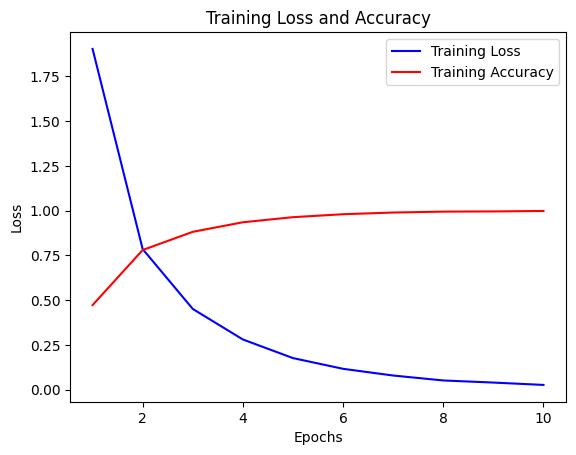

In [44]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get the training/validation loss values
    loss = history.history['loss']
    val_loss = history.history['accuracy']

    # Plot the training/validation loss values
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Training Accuracy')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_training_history(history)


#### Script to save the prediction .csv file as shown in sample_submission.

In [50]:
import tensorflow as tf
import pandas as pd
import os
from tqdm import tqdm
# Set the path to the directory containing the test images
image_dir = 'test_images/'

# Set the path to the saved model
#model_path = 'path/to/saved/model.h5'

# Set the path to save the predictions CSV file
predictions_file = 'predictions.csv'

class_labels = ['bacterial_leaf_blight','bacterial_leaf_streak','bacterial_panicle_blight','blast','brown_spot','dead_heart','downy_mildew','hispa','normal','tungro']

image_names = []
predicted_labels = []
# Create a generator for the test images
for image_name in tqdm(os.listdir(image_dir)):
    # Read the image
    image_path = os.path.join(image_dir, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize the image

    # Expand dimensions to match the input shape expected by the model
    image = tf.expand_dims(image, axis=0)

    # Make a prediction using the model
    prediction = model.predict(image,verbose=0)
    predicted_label = class_labels[prediction.argmax()]

    # Store the image name and predicted label
    image_names.append(image_name)
    predicted_labels.append(predicted_label)

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame({
    'Image': image_names,
    'Predicted Label': predicted_labels
})
# Save the predictions to a CSV file
predictions_df.to_csv(predictions_file, index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3469/3469 [04:30<00:00, 12.84it/s]


#### Creating multimodal transfer learning model, however I realized later that in the dataset I do not have test.csv as I did for training
#### The code should be able to consider that part as well.

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model



# Load pre-trained VGG16 model without the top (fully connected) layers
def create_model(input_shape_csv=None):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new input layer for additional features
    #input_features = Input(shape=(features.shape[1],))
    input_features = Input(shape=(input_shape_csv))

    # Add a fully connected layer for the additional features
    fc = Dense(256, activation='relu')(input_features)
    fc = Flatten()(fc)
    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Concatenate the flattened output with the fully connected layer
    x = Concatenate()([x, fc])

    # Add more layers as needed
    x = Dense(128, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)  # we have 10 classes

    # Create the combined model
    model = Model(inputs=[base_model.input, input_features], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [35]:
import glob as glob
import os
from tensorflow.keras.preprocessing import image as krs_image
import random
# Define image and feature directories


images_dir = 'train_images/'
feature_cols = ['Encoded_variety', 'age']  # feature columns


# Create the arguments for image preprocessing
data_gen_args = dict(
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=10,
    channel_shift_range=50,
    rescale=1. / 255,
)

# Create an empty data generator
datagen = ImageDataGenerator()

# Read the image list and csv
image_file_list  = glob.glob(os.path.join(images_dir, '**', '*.jpg'))

random.shuffle(image_file_list)

def custom_generator(images_list, dataframe, batch_size,num_classes):
    i = 0
    while True:

        images = []
        features_csv = []
        labels = []
        for b in range(batch_size):
            # Read image from list and convert to array
            if i >= len(images_list):
                i = 0
            image_path = images_list[i]
            #print(len(images_list))
            image_name = os.path.basename(image_path).replace('.JPG', '')
            image = krs_image.load_img(image_path, target_size=(224, 224))
            image = krs_image.img_to_array(image)
            image = datagen.apply_transform(image, data_gen_args)

            # Read data from csv using the name of current image
            
            csv_row = dataframe.loc[dataframe['image_id'] == image_name] 
            features = csv_row[feature_cols].values
        
            label = csv_row['labels']

            images.append(image)
            features_csv.append(features)
            labels.append(label)
            #print(i)
            i += 1

        images = np.array(images)
        features_csv = np.array(features_csv)
        # Convert labels to categorical values
    
        labels = np.eye(num_classes)[labels]
        labels = np.reshape(labels, (batch_size, 10))

        yield [images, features_csv], labels
        
training_generator = custom_generator(image_file_list, csv_data, batch_size, NUM_CLASSES)

steps = (len(csv_data)) // batch_size

In [36]:
# Create data generator for image augmentation and loading
model = create_model(2)
model.summary()
history = model.fit(training_generator, steps_per_epoch=steps ,epochs=10, verbose=1)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

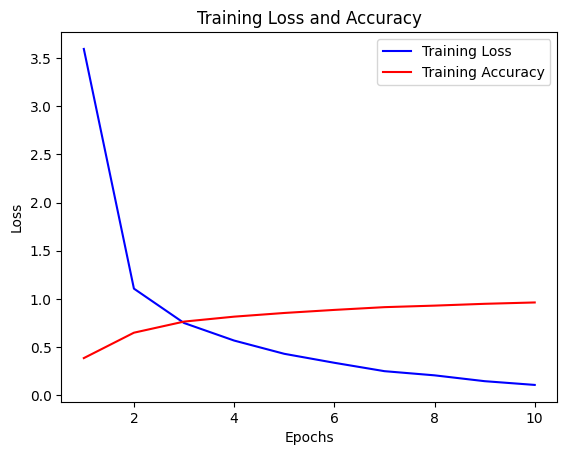

In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get the training/validation loss values
    loss = history.history['loss']
    val_loss = history.history['accuracy']

    # Plot the training/validation loss values
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Training Accuracy')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_training_history(history)
